In [1]:
# Importing necessary libraries

import torch 
import matplotlib.pyplot as plt
import sympy as sym
from torchvision.io import read_image
from torchvision import models
import torch.nn as nn
from torch.nn.modules import activation
from scipy.ndimage import zoom
import numpy as np

## 1) Variants of Backprop for visualizing CNNs


In [2]:
# Downloading the pre-trained ResNet-50 model

# Resnet_50 = models.resnet50(pretrained = True) Old implementation

weights = models.ResNet50_Weights.DEFAULT

Resnet_50 = models.resnet50(weights=weights)

In [3]:
# Architecture of ResNet-50 

Resnet_50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

torch.Size([3, 183, 276])


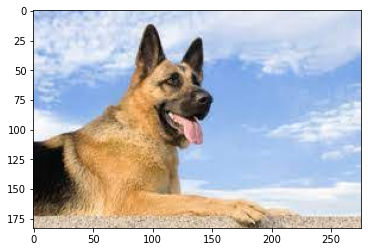

torch.Size([3, 194, 259])


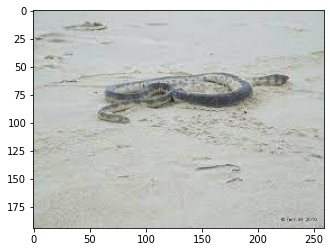

torch.Size([3, 194, 259])


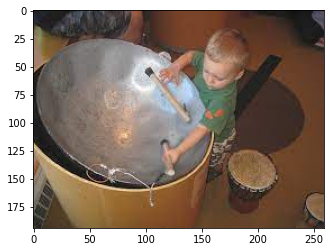

torch.Size([3, 186, 271])


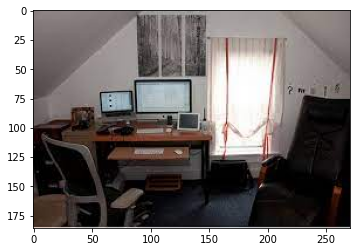

torch.Size([3, 194, 259])


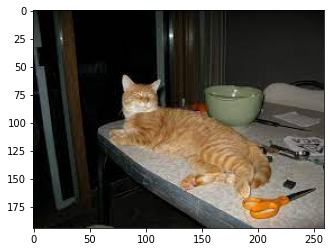

In [4]:
# Loading the images

img1 = read_image("i1.jpg")
print(img1.shape)
img1_display = torch.einsum("chw->hwc",img1)
plt.imshow(img1_display)
plt.show()

img2 = read_image("i2.jpg")
print(img2.shape)
img2_display = torch.einsum("chw->hwc",img2)
plt.imshow(img2_display)
plt.show()

img3 = read_image("i3.jpg")
print(img3.shape)
img3_display = torch.einsum("chw->hwc",img3)
plt.imshow(img3_display)
plt.show()

img4 = read_image("i4.jpg")
print(img4.shape)
img4_display = torch.einsum("chw->hwc",img4)
plt.imshow(img4_display)
plt.show()

img5 = read_image("i5.jpg")
print(img5.shape)
img5_display = torch.einsum("chw->hwc",img5)
plt.imshow(img5_display)
plt.show()


In [5]:
# ResNet-50 takes input image with shape 3 x 224 x 224 so we will preprocess the images

preprocess = weights.transforms()

new_img1 = preprocess(img1)
batch_img1 = new_img1.unsqueeze(0) 

new_img2 = preprocess(img2)
batch_img2 = new_img2.unsqueeze(0)

new_img3 = preprocess(img3)
batch_img3 = new_img3.unsqueeze(0)

new_img4 = preprocess(img4)
batch_img4 = new_img4.unsqueeze(0)

new_img5 = preprocess(img5)
batch_img5 = new_img5.unsqueeze(0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])


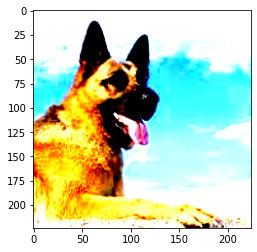

In [6]:
# Viewing the img1

print(new_img1.shape)

plt.imshow(torch.einsum("chw->hwc",new_img1))
plt.show()


In [7]:
print(batch_img1.shape)

torch.Size([1, 3, 224, 224])


### a) Using Vanilla BackProp

In [8]:
def Vanilla_Backprop(batch,model,plot = True):
    
    model.eval()

    batch.requires_grad = True

    output = model(batch)
    model.zero_grad()

    _,pred_class = torch.max(output.data,1)


    v = torch.zeros(1,1000)
    
    v[0][pred_class] = 1

    output.backward(v)
   
    
    grad_map = batch.grad[0].detach()
    
    grad_map = (grad_map - torch.min(grad_map))/(torch.max(grad_map) - torch.min(grad_map))
    if plot :
     
     with torch.no_grad():
      plt.figure(figsize = (10,30))
      plt.subplot(121)
      plt.imshow(torch.einsum("chw->hwc",batch[0]))
      plt.title("Original Image")
        
      plt.subplot(122)
      plt.imshow(torch.einsum("chw->hwc",grad_map))
      plt.title("Visualize using Vanilla_Backprop")
    
      batch.grad.zero_()
    
      plt.show()
    else :
        return grad_map
    
    batch.requires_grad = False


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


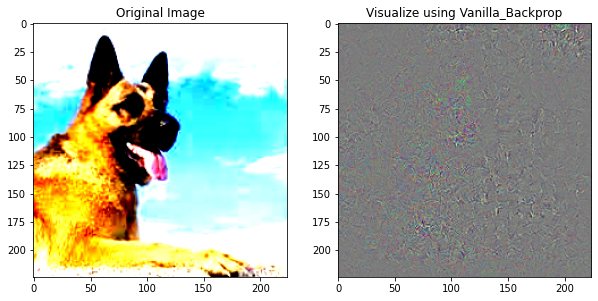

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


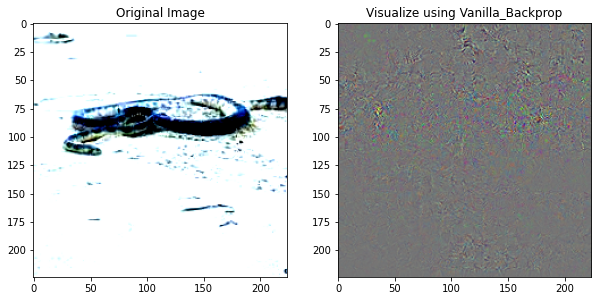

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


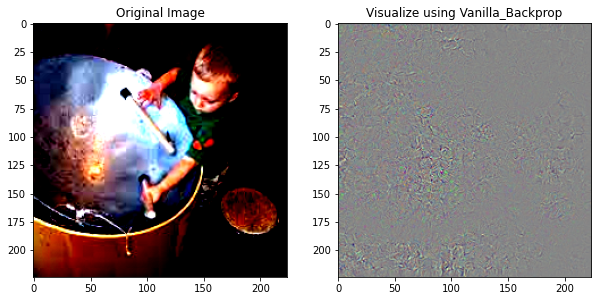

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


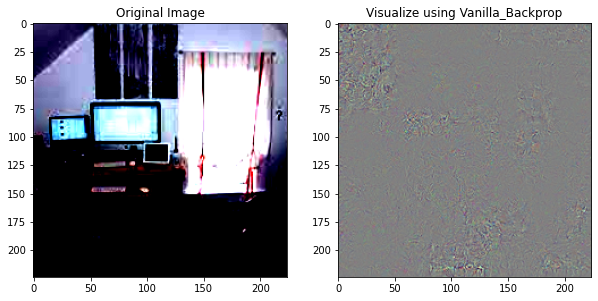

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


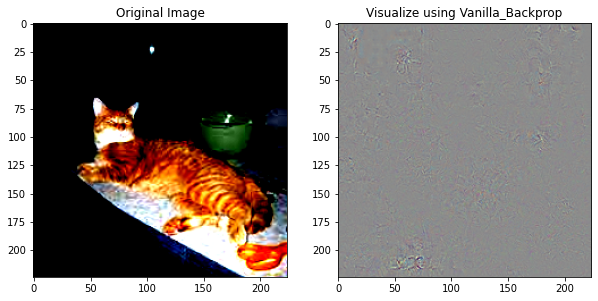

In [9]:
Vanilla_Backprop(batch_img1,Resnet_50)

Vanilla_Backprop(batch_img2,Resnet_50)

Vanilla_Backprop(batch_img3,Resnet_50)

Vanilla_Backprop(batch_img4,Resnet_50)

Vanilla_Backprop(batch_img5,Resnet_50)

### b) Guided Backprop

In [10]:
def ReLU_hook(module,grad_input,grad_output):

    grad_input[0][grad_input[0]<0]=0
    return (grad_input[0],)


def Guided_Backprop(batch,model,plot = True,normalize = True):
   
    model.eval()

 
    handle_list = []
    

    for key,layer in model.named_modules():
       if isinstance(layer,activation.ReLU):
         handle_list.append(layer.register_backward_hook(ReLU_hook))


    batch.requires_grad = True



    output_guided = model(batch)

    model.zero_grad()

    _,pred_class = torch.max(output_guided.data,1)


    v = torch.zeros(1,1000)
    v[0][pred_class] = 1


    output_guided.backward(v)

    for handle in handle_list:
        handle.remove()

    guided_grad_map = batch.grad[0].detach()
    
    normalize_guided_grad_map = (guided_grad_map - torch.min(guided_grad_map))/(torch.max(guided_grad_map) - torch.min(guided_grad_map))
    if plot:
        
      with torch.no_grad():
        
        plt.figure(figsize = (10,30))
    
        plt.subplot(121)
        plt.imshow(torch.einsum("chw->hwc",batch[0]))
        plt.title("Original Image")
        
        plt.subplot(122)
        plt.imshow(torch.einsum("chw->hwc",normalize_guided_grad_map))
        plt.title("Visualize using Guided_Backprop")
    
        batch.grad.zero_()
    
        plt.show()
    else:
     
      if normalize :
        batch.grad.zero_()
        return normalize_guided_grad_map 
      else :

        return guided_grad_map
  
  

/home/charanubuntu/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


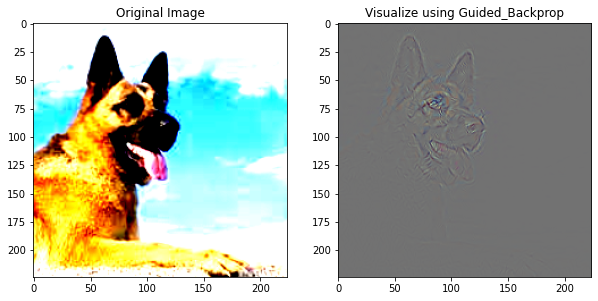

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


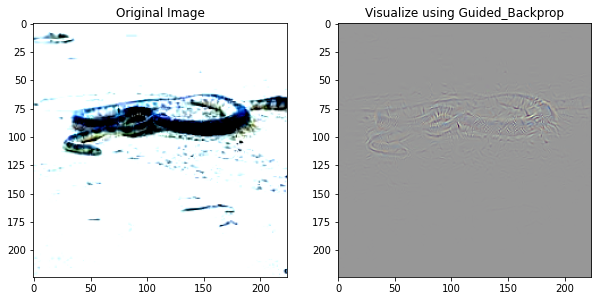

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


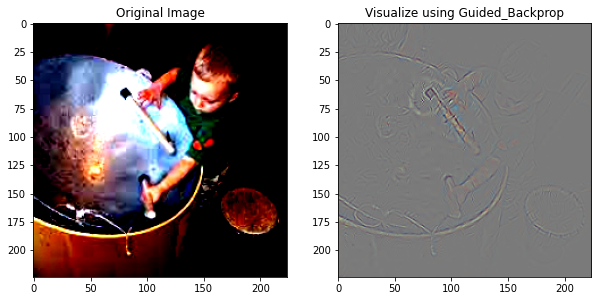

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


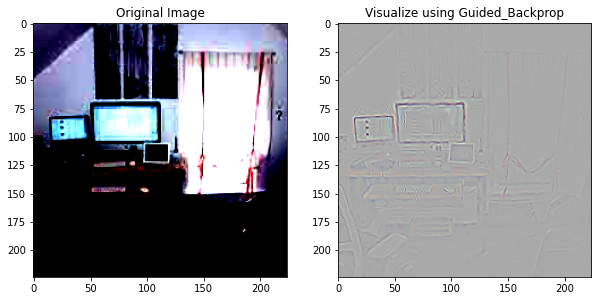

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


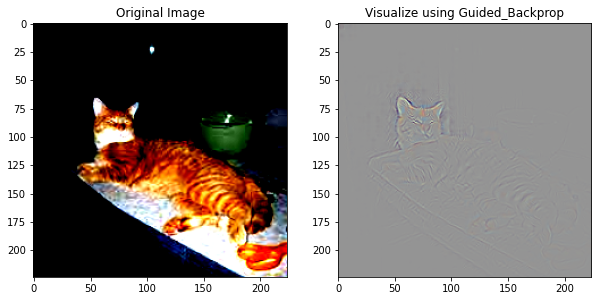

In [11]:
Guided_Backprop(batch_img1,Resnet_50)

Guided_Backprop(batch_img2,Resnet_50)

Guided_Backprop(batch_img3,Resnet_50)

Guided_Backprop(batch_img4,Resnet_50)

Guided_Backprop(batch_img5,Resnet_50)

### c) Class Activation Maps (CAM)

In [12]:
def CAM(batch,model,plot = True):
   
    model.eval()
    
    childrens = list(model.children())
    
    output = model(batch) 
    
    model.zero_grad()

    _,pred_class = torch.max(output.data,1)
   
    weights_class = childrens[9].weight[pred_class]

    Resnet_final_conv_out = nn.Sequential(*childrens[:-2])
    
    Resnet_final_conv_out.eval()


    output_map = Resnet_final_conv_out(batch)

    weighted_sum = torch.einsum("bc,chw->bhw",weights_class,output_map[0])

# Making a copy of 7 x 7 weighted sum map

    weighted_map = weighted_sum[0].detach()

# Normalize the weighted sum map.
    with torch.no_grad():
     
     normalise_weighted_map = (weighted_map - torch.min(weighted_map))/(torch.max(weighted_map) - torch.min(weighted_map))

# Resizing the 7 x 7 to 224 x 224

     CAM = zoom(weighted_map, np.array(batch[0].shape[1:])/np.array(weighted_map.shape))

     if plot:
        
        
       plt.figure(figsize = (20,40))

       plt.subplot(131)
       plt.imshow(CAM)
       plt.title("Class Acivation Map")

       plt.subplot(132)
       plt.imshow(CAM)
       plt.imshow(torch.einsum("chw->hwc",batch[0]), alpha = 0.25)
       plt.title("Class Acivation on Input Image")


       plt.subplot(133)
       plt.imshow(CAM,cmap = "jet")
       plt.imshow(torch.einsum("chw->hwc",batch[0]), alpha = 0.25)
       plt.title("Class Acivation Heat Map on Original Image")
       batch.grad.zero_()
       plt.show()
       
     else :
        batch.grad.zero_()
        return CAM

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


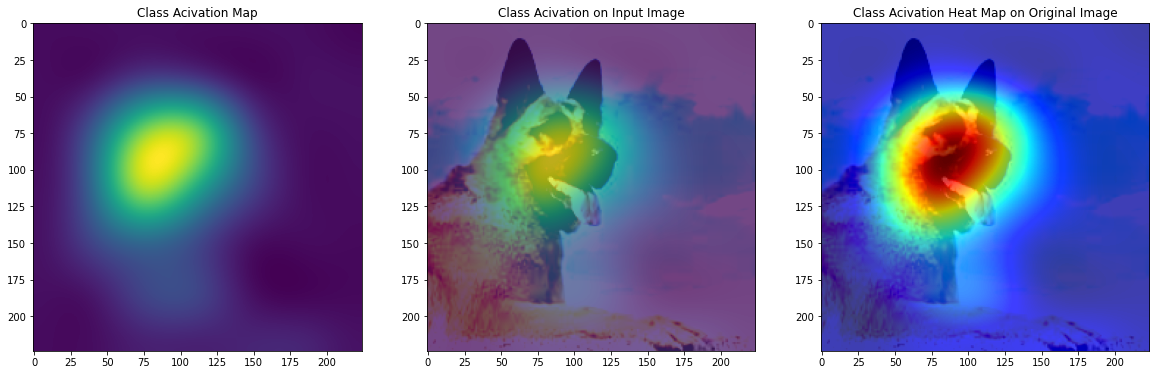

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


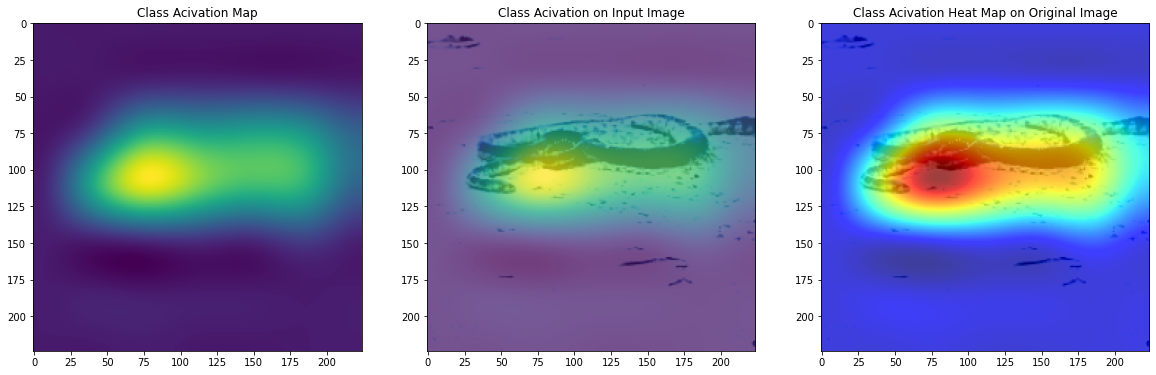

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


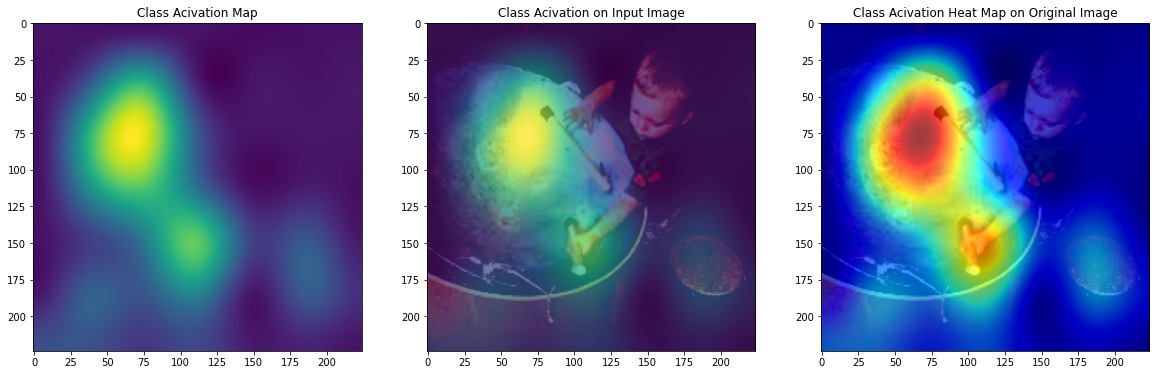

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


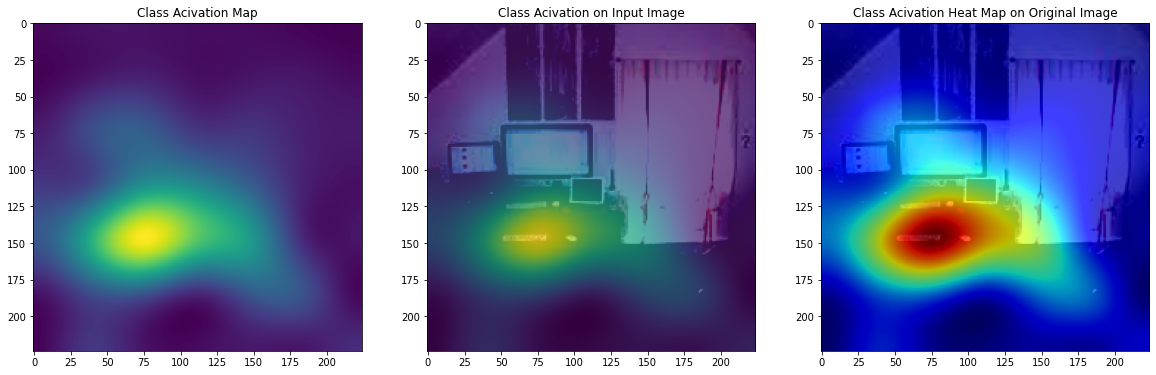

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


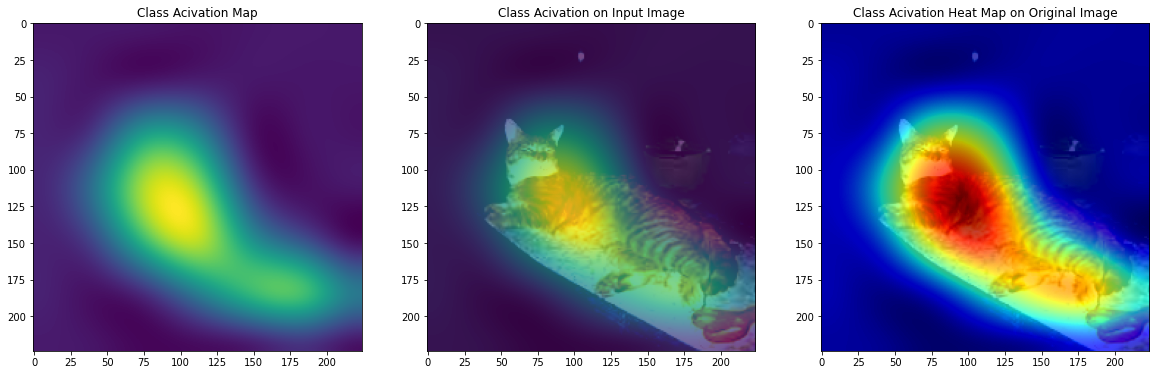

In [13]:
CAM(batch_img1,Resnet_50)

CAM(batch_img2,Resnet_50)

CAM(batch_img3,Resnet_50)

CAM(batch_img4,Resnet_50)

CAM(batch_img5,Resnet_50)

### d) Guided Grad CAM

In [14]:
def Avg_pool(img):
    tot_sum = torch.einsum("chw->",img)
    avg = (tot_sum)/(img.shape[1]*img.shape[2])
    return avg


def GAP_layer(act_conv_vol):
 """
  Perfoms Global Average Pooling on the input activation maps.
  
  Argument -> act_conv_vol : (C x H x W)
 """
 C = act_conv_vol.shape[0]
    
 GAP_output = []

 for c in range(C):
        
    avg_out = Avg_pool(act_conv_vol[c:c+1,:,:])
    
    GAP_output.append(avg_out)
    
 return torch.tensor(GAP_output).reshape(len(GAP_output),1,1)

In [15]:
def GAP_hook(model,grad_in,grad_out):
    
    global grad_maps
    grad_maps = grad_in[0]
    return grad_in



def Guided_Grad_CAM(batch,model,plot = True):
    
    model.eval()


    for key,layer in Resnet_50.named_modules():
   
       if key == 'avgpool':
           GAP_handle = layer.register_backward_hook(GAP_hook)

    batch.requires_grad = True
    childrens = list(model.children())

    Resnet_final_conv_out = nn.Sequential(*childrens[:-2])
    
    output = model(batch)

    _,pred_class = torch.max(output.data,1)

    v = torch.zeros(1,1000)
    
    v[0][pred_class] = 1

    model.zero_grad()

    output.backward(v)

    GAP_handle.remove()

    Resnet_final_conv_out.eval()

    GAP_output = GAP_layer(grad_maps[0])

    weights = GAP_output.squeeze(2)

    Rect_feat_maps = Resnet_final_conv_out(batch)

    Rect_feat_maps = Rect_feat_maps.detach()
    
   
   
    weighted_map_grad = torch.einsum("cb,chw->bhw",weights,Rect_feat_maps[0])

    weighted_map_grad[weighted_map_grad < 0] = 0

    weighted_map_grad = weighted_map_grad[0]

# Normalize the weighted sum map.
    weighted_map_grad = (weighted_map_grad - torch.min(weighted_map_grad))/(torch.max(weighted_map_grad) - torch.min(weighted_map_grad))

# Resizing the 7 x 7 to 224 x 224
    grad_cam = zoom(weighted_map_grad, np.array(batch[0].shape[1:])/np.array(weighted_map_grad.shape))
    
    grad_cam = torch.tensor(grad_cam).unsqueeze(0)

# Grad cam and Guided Back prop element wise multiplication
       
    guided_grad_cam = Guided_Backprop(batch,model,plot = False,normalize = False)*grad_cam

# Normalize the Guided Grad CAM.

    normalise_guided_grad_cam = (guided_grad_cam - torch.min(guided_grad_cam))/(torch.max(guided_grad_cam) - torch.min(guided_grad_cam))
    
    with torch.no_grad():
        
         if plot :
            
            plt.figure(figsize = (10,30))
    
            plt.subplot(121)
            plt.imshow(torch.einsum("chw->hwc",batch[0]))
            plt.title("Original Image")
        
            plt.subplot(122)
            plt.imshow(torch.einsum("chw->hwc",normalise_guided_grad_cam))
            plt.title("Visualize using Guided Grad CAM")
    
            batch.grad.zero_()
        
            plt.show()
            
         else:
            return normalise_guided_grad_cam

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


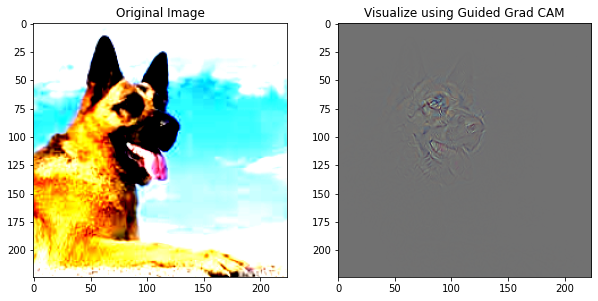

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


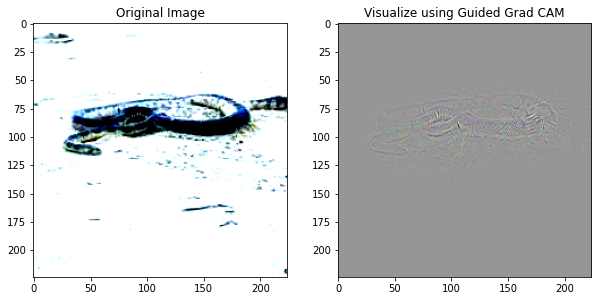

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


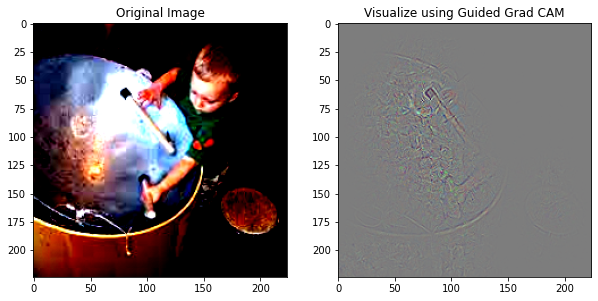

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


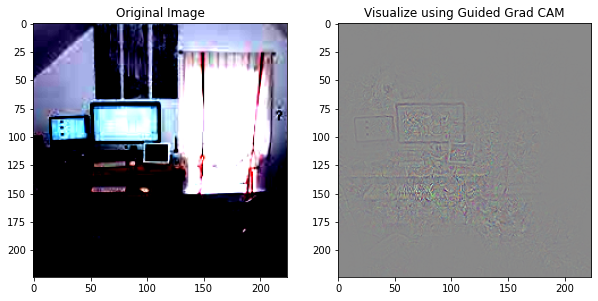

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


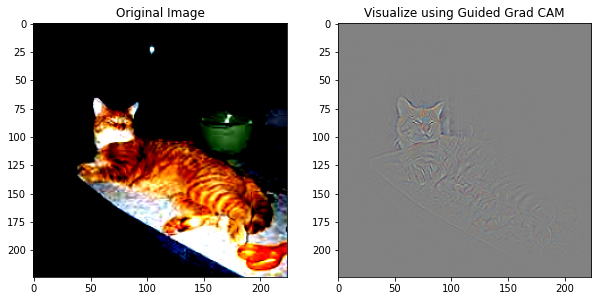

In [16]:
Guided_Grad_CAM(batch_img1,Resnet_50)

Guided_Grad_CAM(batch_img2,Resnet_50)

Guided_Grad_CAM(batch_img3,Resnet_50)

Guided_Grad_CAM(batch_img4,Resnet_50)

Guided_Grad_CAM(batch_img5,Resnet_50)

## 2) SGD Update rule Variations

In [17]:
class Function2D():
    
     
    def __init__(self,cus_func = False,func = None):
        """ 
         Constructer initialised with the default function being f(x,y) = 10x^2 + y^2.
         For custom function set *cus_func* -> True and pass function's sympy expression 
         to *func*.
         
        """
        if not cus_func:
           x = sym.Symbol('x')
           y = sym.Symbol('y')
           self.func = 10*x**2 + y**2
        else :
            self.func = func
    
    # Prints the sympy expression of the function.
    def get_exp(self):
        
        print(self.func)
    
    def get_val(self,point):
        x = sym.Symbol('x')
        y = sym.Symbol('y')
        point = point[0]
        
        x1 = point[0]
        y1 = point[1]
        
        func = self.func
        func_value = float(func.subs([(x,x1),(y,y1)]))
        
        return torch.tensor(func_value).reshape(1,1)
    
    def get_grad_x(self,x1):
        x = sym.Symbol('x')
        func = self.func
#         print(type(func))
#         print(type(x))
        par_der = func.diff(x)
#         print(par_der)
        grad_x_val = par_der.subs(x,x1)
        
        return grad_x_val
    
    def get_grad_y(self,y1):
        y = sym.Symbol('y')
        func = self.func
        par_der = func.diff(y)
        grad_y_val = par_der.subs(y,y1)
        
        return grad_y_val
    
    def get_grad_vec(self,point):
        point = point.view(-1)
        x1 = point[0]
        y1 = point[1]
        dx1 = float(self.get_grad_x(x1))
        dy1 = float(self.get_grad_y(y1))
        grad_vec = torch.tensor([dx1,dy1]).reshape(2,1)
        
        return grad_vec
  
    

In [18]:

Obj_func = Function2D()

# Starting point
ini_point = torch.tensor([10,10]).reshape(2,1)

# max no.of iterations

max_iter = 60

algo_points = []

### a) Using Vanilla SGD

 > Vanilla SGD is an optimization technique which is used to optimize the objective function $J(\omega)$ by updating the parameters involved $(\omega)$ as follows,
   $$
    \begin{align}
      \omega_{i + 1} &= \omega_i - \eta*(\nabla_{\omega}J)_{\omega_i}
    \end{align}
   $$
  where $\omega_i$ is the $i^{th}$ weight vector.        
        $\eta$ is the step size or learning rate.    
        $\nabla_{\omega}J$ is the gradient w.r.t $\omega$ evaluated at $\omega_i$.
   
**Note** : Here the technique is stated in the context of the question.

In [19]:
def VanillaSGD(func,start_point,η,max_iter):
    
    points = start_point.reshape(1,2,1)
    update_point = start_point
    total_points = torch.cat((start_point,func.get_val(start_point.reshape(1,2,1)))).reshape(1,3,1)     
    
    for i in range(max_iter):
        learn_value = func.get_grad_vec(update_point)
        
        update_point = update_point -  η*(learn_value)
        
        total_upd_point = torch.cat((update_point,func.get_val(update_point.reshape(1,2,1))))
        
        total_points = torch.cat((total_points,total_upd_point.unsqueeze(0)))
        
        points = torch.cat((points,update_point.reshape(1,2,1)))
       
    
    return total_points

In [20]:
η_van = 0.04


Vanilla_points = VanillaSGD(Obj_func,ini_point,η_van,max_iter)

algo_points.append(Vanilla_points)

### b) SGD + Momentum

In [21]:
def SGD_Momentum(func,start_point,η,ρ,max_iter):
    
    points = start_point.reshape(1,2,1)
    update_point = start_point
    total_points = torch.cat((start_point,func.get_val(start_point.reshape(1,2,1)))).reshape(1,3,1)
    vel_i = 0
    for i in range(max_iter):
        learn_value = func.get_grad_vec(update_point)
        vel_i = ρ*vel_i + learn_value 
        update_point = update_point -  η*vel_i
        total_upd_point = torch.cat((update_point,func.get_val(update_point.reshape(1,2,1))))
        total_points = torch.cat((total_points,total_upd_point.unsqueeze(0)))
        points = torch.cat((points,update_point.reshape(1,2,1)))
       
    
    return total_points

In [22]:
η_SGDmoment = 0.04
ρ_SGDmoment = 0.92


SGDmoment_points = SGD_Momentum(Obj_func,ini_point,η_SGDmoment,ρ_SGDmoment,max_iter)

In [23]:
algo_points.append(SGDmoment_points)

### c) Nesterov Momentum

In [24]:
def Nesterov(func,start_point,η,ρ,max_iter):
    
    points = start_point.reshape(1,2,1)
    update_point = start_point
    total_points = torch.cat((start_point,func.get_val(start_point.reshape(1,2,1)))).reshape(1,3,1)
    vel_i = 0
    for i in range(max_iter):
     
        learn_value = func.get_grad_vec(update_point + ρ*vel_i)
        
        vel_i = ρ*vel_i + learn_value 
        update_point = update_point -  η*vel_i
        total_upd_point = torch.cat((update_point,func.get_val(update_point.reshape(1,2,1))))
        total_points = torch.cat((total_points,total_upd_point.unsqueeze(0)))
        points = torch.cat((points,update_point.reshape(1,2,1)))
       
    
    return total_points

In [25]:
η_nesterov = 0.04
ρ_nesterov = 0.02

Nesterov_points = Nesterov(Obj_func,ini_point,η_nesterov,ρ_nesterov,max_iter)

In [26]:
algo_points.append(Nesterov_points)

### d) AdaGrad

In [27]:
def AdaGrad(func,start_point,η,ϵ,max_iter):
    
    points = start_point.reshape(1,2,1)
    update_point = start_point
    total_points = torch.cat((start_point,func.get_val(start_point.reshape(1,2,1)))).reshape(1,3,1)
    learn_val_sq = 0
    
    for i in range(max_iter):
        learn_value = func.get_grad_vec(update_point)
        
        norm = torch.linalg.norm(learn_value)
        
        learn_val_sq = learn_val_sq + norm**2
        
        update_point = update_point -  η*(learn_value)/(torch.sqrt(learn_val_sq) + ϵ)
        
        total_upd_point = torch.cat((update_point,func.get_val(update_point.reshape(1,2,1))))
        
        total_points = torch.cat((total_points,total_upd_point.unsqueeze(0)))
        
        points = torch.cat((points,update_point.reshape(1,2,1)))
       
    
    return total_points

In [28]:
η_AdaGrad = 4.8
ϵ_AdaGrad = 1e-6

AdaGrad_points = AdaGrad(Obj_func,ini_point,η_AdaGrad,ϵ_AdaGrad,max_iter)

In [29]:
algo_points.append(AdaGrad_points)

### e) RMSProp

In [30]:
def RMSProp(func,start_point,η,ρ,ϵ,max_iter):
    
    points = start_point.reshape(1,2,1)
    update_point = start_point
    total_points = torch.cat((start_point,func.get_val(start_point.reshape(1,2,1)))).reshape(1,3,1)
    learn_val_sq = 0
    
    for i in range(max_iter):
        learn_value = func.get_grad_vec(update_point)
        
        norm = torch.linalg.norm(learn_value)
        
        learn_val_sq = ρ*learn_val_sq + (1-ρ)*(norm**2)
        
        update_point = update_point -  η*(learn_value)/(torch.sqrt(learn_val_sq) + ϵ)
        
        total_upd_point = torch.cat((update_point,func.get_val(update_point.reshape(1,2,1))))
        
        total_points = torch.cat((total_points,total_upd_point.unsqueeze(0)))
        
        points = torch.cat((points,update_point.reshape(1,2,1)))
       
    
    return total_points

In [31]:
η_RMSProp = 0.99
ϵ_RMSProp = 1e-6
ρ_RMSProp = 0.9



RMSProp_points = RMSProp(Obj_func,ini_point,η_RMSProp,ρ_RMSProp,ϵ_RMSProp,max_iter)


In [32]:
algo_points.append(RMSProp_points)

In [33]:
def Contour():
    
 x1 = np.linspace(-30,30,1000)
 x2 = np.linspace(-30,30,1000)

 X1, X2 = np.meshgrid(x1, x2)

 Y = 10*X1**2 + X2**2

 fig,ax=plt.subplots(1,1)

 cp = plt.contourf(X1, X2, Y)

 plt.colorbar(cp)
 

/tmp/ipykernel_45290/2974454911.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax=plt.subplots(1,1)


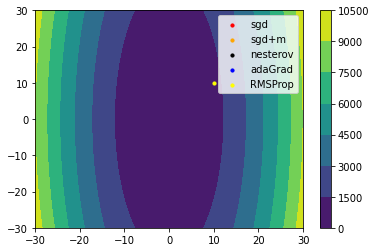

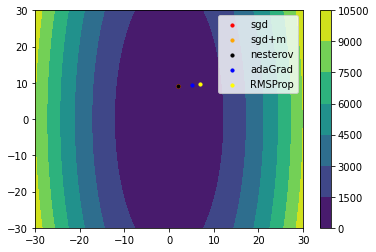

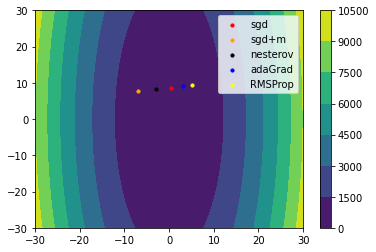

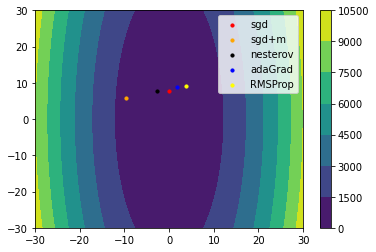

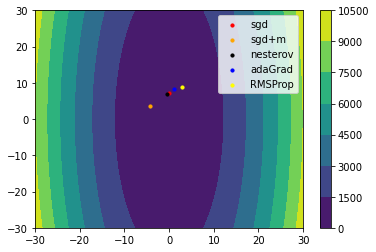

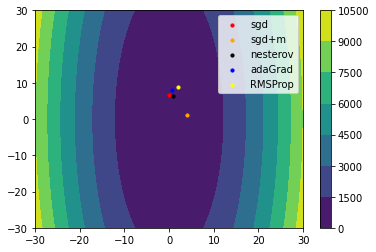

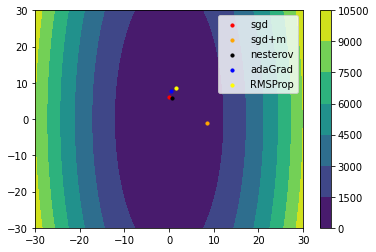

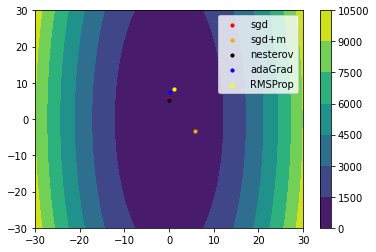

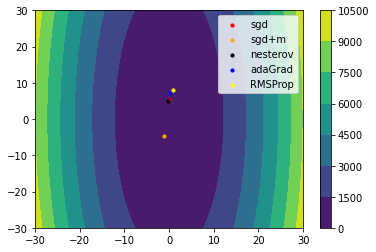

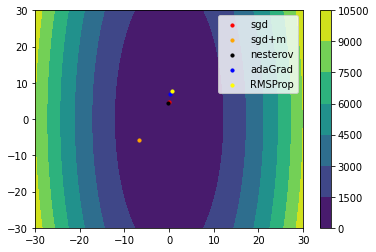

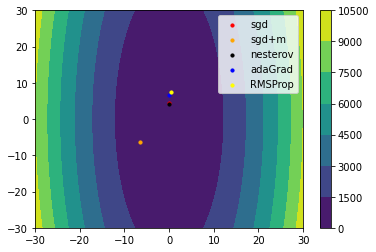

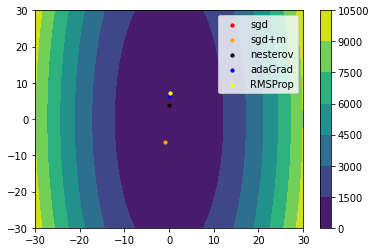

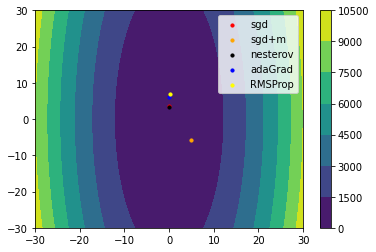

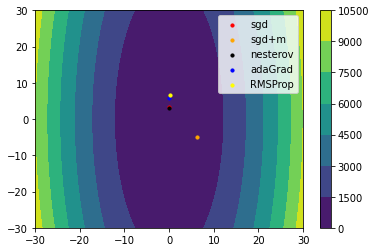

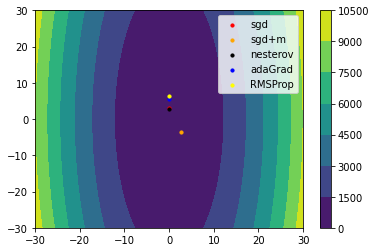

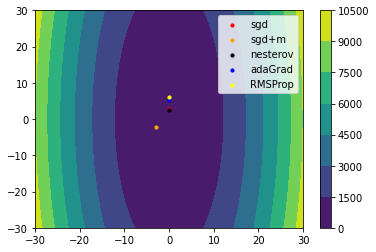

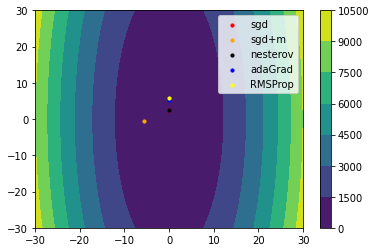

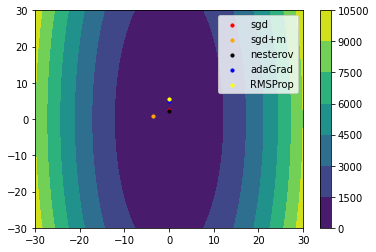

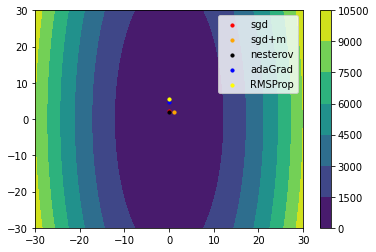

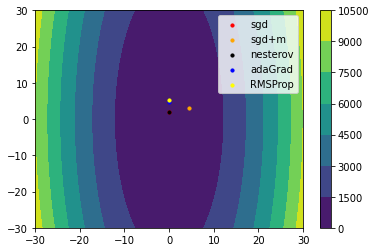

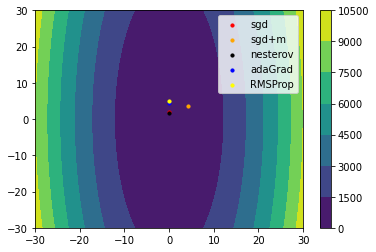

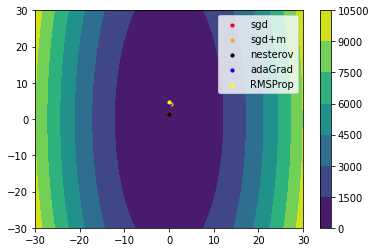

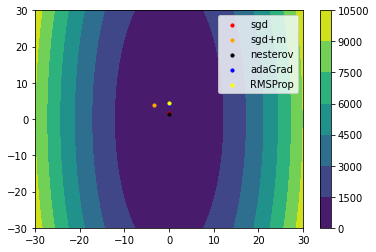

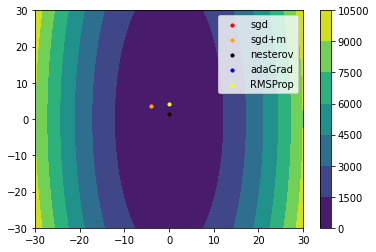

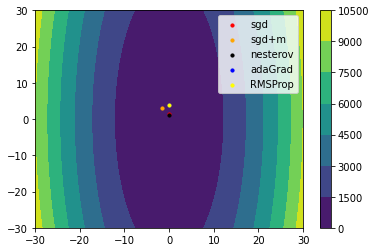

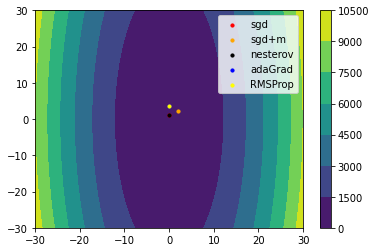

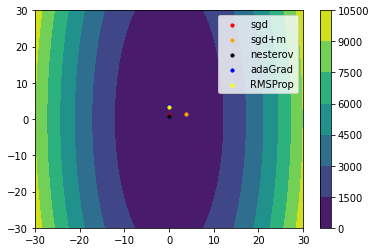

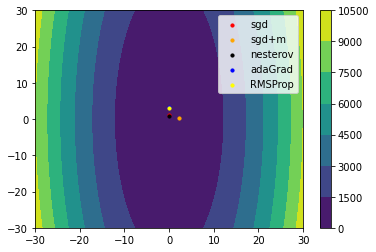

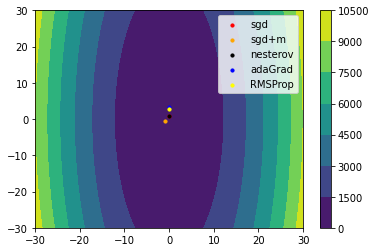

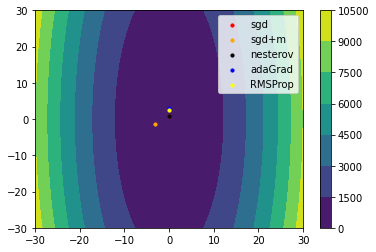

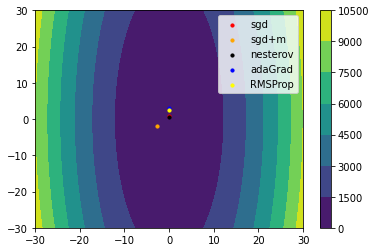

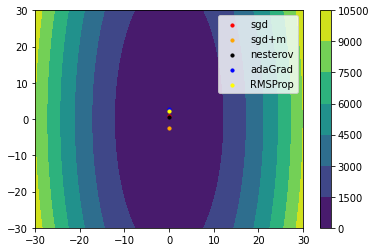

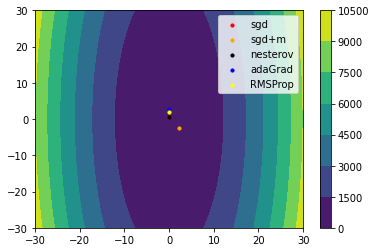

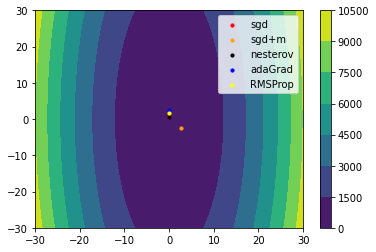

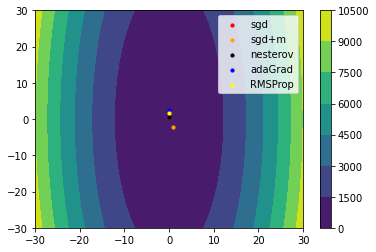

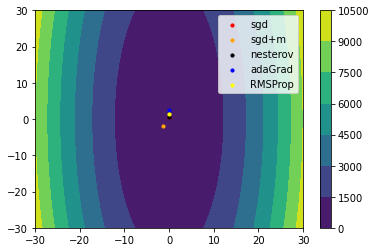

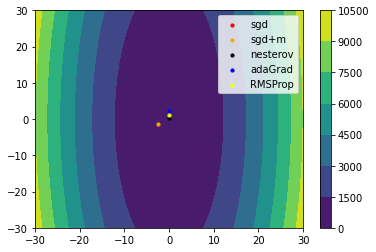

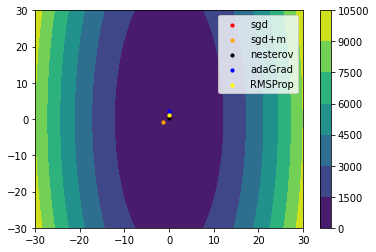

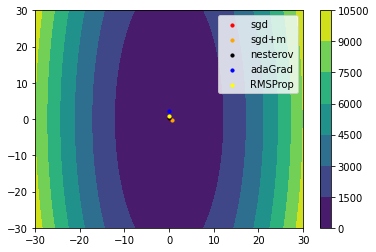

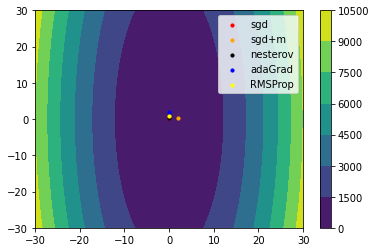

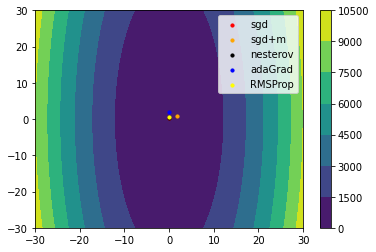

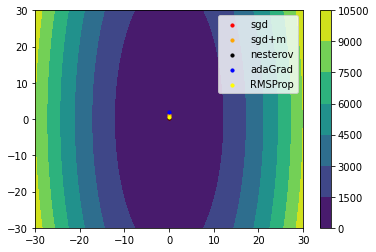

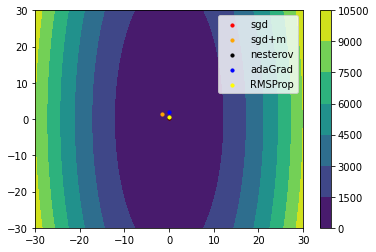

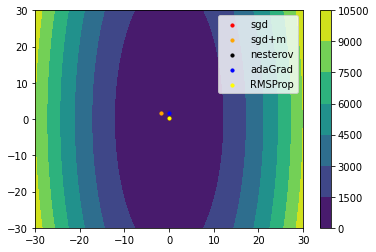

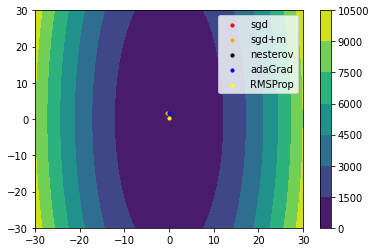

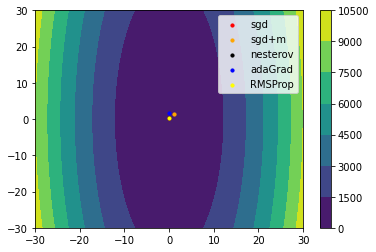

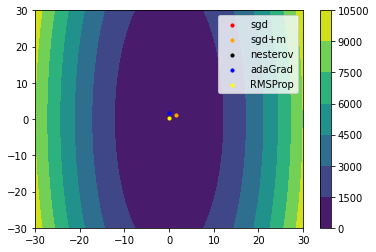

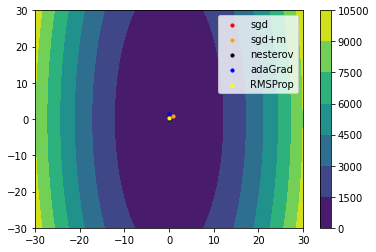

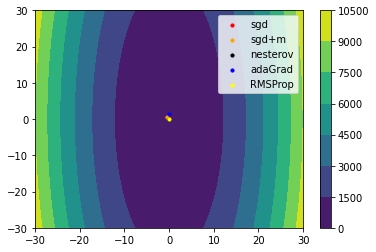

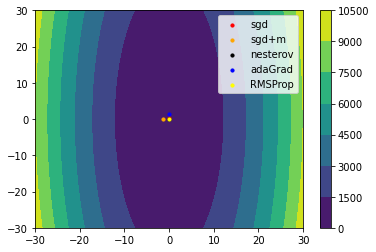

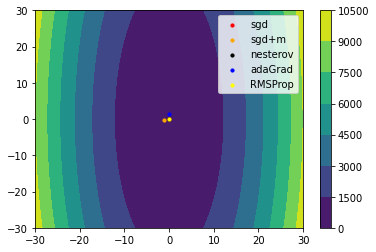

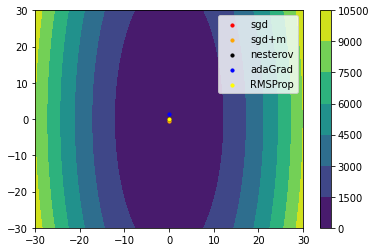

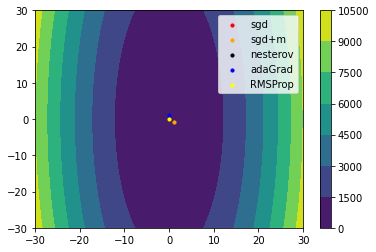

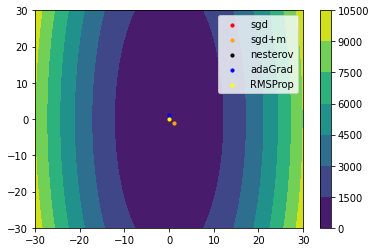

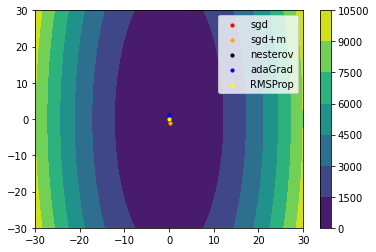

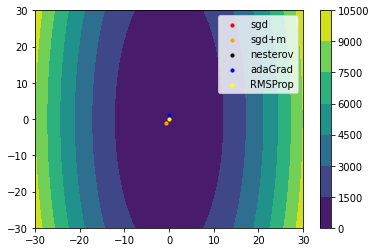

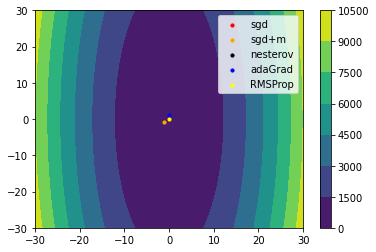

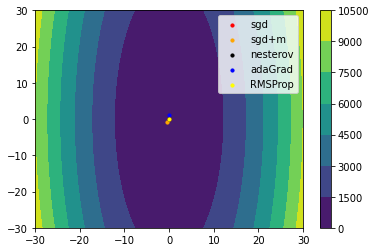

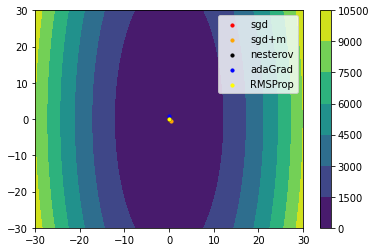

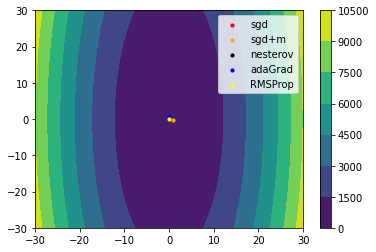

In [34]:
colors = ['red','orange','black','blue','yellow']
label = ['sgd','sgd+m','nesterov','adaGrad','RMSProp']

for j in range(max_iter):
  Contour()
  for i in range(len(algo_points)):
    plt.scatter(algo_points[i][:,0][j],algo_points[i][:,1][j],s = 10,c = colors[i],label = label[i])
  plt.legend()
  plt.savefig("gif_images/iter{}.png".format(j))


In [35]:
import imageio.v2

images = []

for i in range(max_iter):
    images.append(imageio.v2.imread("gif_images/iter{}.png".format(i)))
    
imageio.mimsave('update_rules.gif',images)